# Práctica de calibración de cámaras

Visión por Computador <br>
Practica 2. 2 de noviembre de 2020

Este enunciado está en el archivo "PracticaCalib2020.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

Autor 1: Fernando Planes Ruiz
<br>Autor 2: Alejandro Muñoz Navarro

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, implementado en OpenCV.
* Hacer uso de los resultados de la calibración para tomar diferentes medidas en las imágenes.
* Calibrar una cámara a partir de una imagen de una escena en la que se desconoce las coordenadas de sus puntos.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* Dos secuencias de imágenes tomadas con un par de cámaras estéreo (izquierda y derecha) en los directorios ``left`` y ``right``.
* Un conjunto de imágenes de alta resolución un edificio, ``building``.

## Condiciones

* La fecha límite de entrega será el lunes 9 de noviembre a las 23:55.
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [1]:
# uncomment to show results in a window
# %matplotlib tk
import cv2
import glob
import copy
import numpy as np
import scipy.misc as scpm
import matplotlib.pyplot as plt

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [2]:
def load_images(filenames):
    """Load multiple images."""
    return [cv2.imread(filename) for filename in filenames]

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [3]:
filenames = sorted(glob.glob('./left/*'))

imgs = load_images(filenames)

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) (*columnas x filas*). Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [4]:
corners = [cv2.findChessboardCorners(img, (8, 6)) for img in imgs]

In [5]:
# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
corners2 = copy.deepcopy(corners)

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
cornersRefined = [cv2.cornerSubPix(cv2.cvtColor(imgs[i], cv2.COLOR_RGB2GRAY), corners2[i][1], (5, 5), (-1, -1), criteria) for i in range(len(imgs))]

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [6]:
imgs2 = copy.deepcopy(imgs)

imgs2 = [cv2.drawChessboardCorners(imgs2[i], (8, 6), cornersRefined[i], corners2[i][0]) for i in range(len(imgs2))]

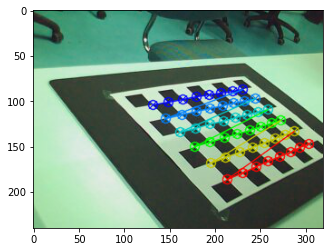

In [7]:
plt.imshow(imgs2[0])

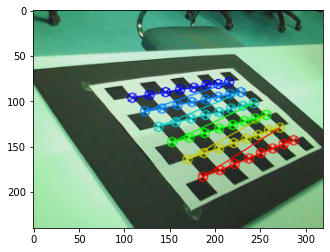

In [8]:
plt.imshow(imgs2[1])

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$, resp. (*columna, fila, 0*),  de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos (*columnas, filas*) de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [9]:
def get_chessboard_points(chessboard_shape, dx, dy): 
    return np.array([[x * dx, y * dx, 0] for x in range(min(chessboard_shape)) for y in range(max(chessboard_shape))], dtype = np.float32)

cb_points = get_chessboard_points((8, 6), 30, 30)
print(cb_points)

[[  0.   0.   0.]
 [  0.  30.   0.]
 [  0.  60.   0.]
 [  0.  90.   0.]
 [  0. 120.   0.]
 [  0. 150.   0.]
 [  0. 180.   0.]
 [  0. 210.   0.]
 [ 30.   0.   0.]
 [ 30.  30.   0.]
 [ 30.  60.   0.]
 [ 30.  90.   0.]
 [ 30. 120.   0.]
 [ 30. 150.   0.]
 [ 30. 180.   0.]
 [ 30. 210.   0.]
 [ 60.   0.   0.]
 [ 60.  30.   0.]
 [ 60.  60.   0.]
 [ 60.  90.   0.]
 [ 60. 120.   0.]
 [ 60. 150.   0.]
 [ 60. 180.   0.]
 [ 60. 210.   0.]
 [ 90.   0.   0.]
 [ 90.  30.   0.]
 [ 90.  60.   0.]
 [ 90.  90.   0.]
 [ 90. 120.   0.]
 [ 90. 150.   0.]
 [ 90. 180.   0.]
 [ 90. 210.   0.]
 [120.   0.   0.]
 [120.  30.   0.]
 [120.  60.   0.]
 [120.  90.   0.]
 [120. 120.   0.]
 [120. 150.   0.]
 [120. 180.   0.]
 [120. 210.   0.]
 [150.   0.   0.]
 [150.  30.   0.]
 [150.  60.   0.]
 [150.  90.   0.]
 [150. 120.   0.]
 [150. 150.   0.]
 [150. 180.   0.]
 [150. 210.   0.]]


**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

In [10]:
# Extract the list of valid images with all corners
valid_corners = [imgs[i] for i in range(len(corners)) if corners[i][0]]
num_valid_images = len(valid_corners)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_points = np.tile(cb_points, (num_valid_images, 1, 1))
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_points = np.array([corners[i][1][:, 0, :] for i in range(len(corners)) if corners[i][0]])

# Calibrate for square pixels corners standard
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imgs[0].shape[1::-1], None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n", intrinsics)
print("Corners standerd dist_coefs:", dist_coeffs)
print("rms:", rms)

Corners standard intrinsics:
 [[420.90487219   0.         150.55695082]
 [  0.         420.90487219 128.06722665]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[-2.33736396e-01  2.66140349e+00  5.62173091e-03 -5.60831347e-03
  -1.78971173e+01]]
rms: 0.18503849221990823


Dibujamos los ejes del sistema de referencia elegido a modo de comprobación.

<ipython-input-11-36750828ad3d>:3: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 3)
<ipython-input-11-36750828ad3d>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 3)
<ipython-input-11-36750828ad3d>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 3)


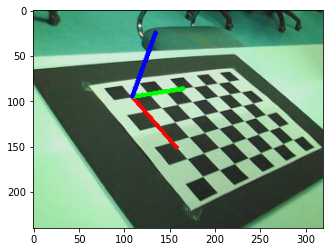

In [11]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 3)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 3)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 3)
    return img

def showAxes(imName, patternSize, dx, dy, intrinsics, dist_coeffs, axlen):
    img = cv2.imread(imName)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)

    if ret == True:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
        
        objp = get_chessboard_points(patternSize, dx, dy)
        
        # Find the rotation and translation vectors.
        retval, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, intrinsics, dist_coeffs)
        
        axis = np.float32([[axlen, 0, 0], [0, axlen, 0], [0, 0, axlen]]).reshape(-1,3)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, intrinsics, dist_coeffs)
 
        cv2.cvtColor(draw(img, corners2, imgpts), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        
showAxes('./left/left_001.jpg', (8, 6), 30, 30, intrinsics, dist_coeffs, 100)

###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Respuesta:** 
*Para este ejercicio hemos planteado 2 posibles soluciones con las que llegamos a la misma solución.*

*En la primera, obtenemos la diagonal FOV como la tangente entre la mitad de la diagonal del sensor y la focal F calculada previamente.*

*En la segunda, calculamos la focal en X y en Y, las cuales multiplicaremos por 2 porque estamos calculando medio ángulo. Después, dividiremos cada uno de los catetos entre su nueva focal anteriormente calculada. Calculamos su distancia elevandolas al cuadrado, sumándolas y realizando la raiz cuadrada.*

*Finalmente pasaremos el resultado a grados.*

In [12]:
import math

fov_diag = 2 * math.atan2(((60 - 10)**2 + (60 - 10)**2)**(.5) / 2, intrinsics[0,0]) * 180.0 / math.pi;
print(fov_diag)

focal_x = intrinsics[0][0]
focal_y = intrinsics[1][1]
W = 60-10
H = 60-10
radians = 2 * math.atan(math.sqrt((W/(2*focal_x))**2 + (H/(2*focal_y))**2))
print(radians * 180 / math.pi)

9.60296551465241
9.60296551465241


**Ejercicio 6.** Calcula cuánto se ha trasladado la cámara entre las imágenes ``left_002.jpg``  y ``left_0014.jpg``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Respuesta:** <br>
*El vector de traslación asociado a la homografía de cada imagen indica la posición de la cámara en el espacio al ser tomada la fotografía. Por tanto la traslación de la cámara entre una imagen y otra será la distancia entre los vectores de traslación.*

*Para calcular la distancia de los vectores de traslación realizaremos la norma de la diferencia entre la matriz de traslación de la segunda imagen y la primera. Primeramente, calcularemos el vector de traslación de la primera imagen en el segundo plano. Para ello aplicaremos la transpuesta de su matriz de rotación y a continuación le aplicaremos la matriz de rotación de la segunda imagen.*

*Finalmente, realizaremos la diferencia entre la traslación de la seguna imagen y la primera, y calcularemos su norma.* 

*Para calcular la norma, se ha usado la función de la librería Numpy: linalg.norm( )*

In [13]:
# Obtenemos los vectores de rotación y traslación de las 2 imágenes
rvec2 = rvecs[2]
rvec14 = rvecs[14]
T1 = tvecs[2]
T2 = tvecs[14]

# Transformamos los vectores de rotación en matrices usando Rodrigues
R1, resto = cv2.Rodrigues(rvec2)
R2, resto = cv2.Rodrigues(rvec14)

# Calculamos la traslación de las imágenes como la norma de: R2 * (-R1' * T1) + T2 

T = np.linalg.norm(np.dot(R2,np.dot(-R1.T,T1)) + T2)

print(T)

294.57176555905767


## 2. Par de cámaras estéreo

**Ejercicio 7.** ¿Cuál es la distancia, en milímetros, entre las dos cámaras de par estéreo?

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: Calibra la cámara derecha usando la secuencia de imágenes del directorio ``right`` y estima dicha distancia.

**Respuesta:** <br>
*Calibramos la cámara a partir de las nuevas imágenes contenidas en el directorio ``right``. Una vez realizado este paso, obtenemos la distancia del vector de traslación en cada imagen comparando ``left`` y ``right``. Para calcular la distancia de las cámaras, hemos realizado la media de estas distancias calculadas previamente.*

In [14]:
filenamesR = sorted(glob.glob('./right/*'))

imgsR = load_images(filenamesR)
cornersR = [cv2.findChessboardCorners(imgR, (8, 6)) for imgR in imgsR]

# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
corners2R = copy.deepcopy(cornersR)

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteriaR = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
#cornersRefinedR = [cv2.cornerSubPix(cv2.cvtColor(imgsR[i],cv2.COLOR_RGB2GRAY), corners2R[i][1],(5,5), (-1,-1), criteriaR) for i in range(len(imgsR))]

cb_pointsR = get_chessboard_points((8, 6), 30, 30)

# Extract the list of valid images with all corners
valid_cornersR = [imgsR[i] for i in range(len(cornersR)) if cornersR[i][0]]
num_valid_imagesR = len(valid_cornersR)

# Prepare input data 
# object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
object_pointsR = np.tile(cb_pointsR, (num_valid_imagesR, 1, 1))
# image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
image_pointsR = np.array([cornersR[i][1][:, 0, :] for i in range(len(cornersR)) if cornersR[i][0]])

# Calibrate for square pixels corners standard
rmsR, intrinsicsR, dist_coeffsR, rvecsR, tvecsR = cv2.calibrateCamera(object_pointsR, image_pointsR, imgsR[0].shape[1::-1], None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("CALIBRACIÓN DE LA CÁMARA DERECHA:\n")
print("Corners standard intrinsics:\n", intrinsicsR)
print("Corners standerd dist_coefs:", dist_coeffsR)
print("rms:", rmsR)
print("DISTANCIA ENTRE CÁMARAS:\n")

minimo = min(len(rvecs),len(rvecsR))
media = 0
for i in range(minimo):
    rvec1 = rvecs[i]
    rvec2 = rvecsR[i]
    T1 = tvecs[i]
    T2 = tvecsR[i]

    R1, resto = cv2.Rodrigues(rvec1)
    R2, resto = cv2.Rodrigues(rvec2)

    T = np.linalg.norm(np.dot(R2,np.dot(-R1.T,T1)) + T2)
    print("Distancia imagen" + str(i) + ": ", T)
    media = media + T

media = media/minimo
print("Traslación de la cámara:",media)

CALIBRACIÓN DE LA CÁMARA DERECHA:

Corners standard intrinsics:
 [[431.62482534   0.         143.27814352]
 [  0.         431.62482534 134.90858932]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[-0.12083201  0.00250115  0.00755138 -0.00660617  0.22763318]]
rms: 0.14573331222117916
DISTANCIA ENTRE CÁMARAS:

Distancia imagen0:  60.69133326865301
Distancia imagen1:  76.51889013774834
Distancia imagen2:  68.46929732138523
Distancia imagen3:  70.15058272096947
Distancia imagen4:  78.3125214033189
Distancia imagen5:  83.88396500481235
Distancia imagen6:  73.6227283500195
Distancia imagen7:  75.79091906633087
Distancia imagen8:  79.81449144731197
Distancia imagen9:  80.38896668184572
Distancia imagen10:  98.38621067772328
Distancia imagen11:  87.02540453809638
Distancia imagen12:  92.98249175301552
Distancia imagen13:  104.43783471389472
Distancia imagen14:  86.52516910992355
Distancia imagen15:  83.25466089153346
Distancia imagen16:  62.70586524507979
Traslación d

## 3. Calibración a partir de una imagen

En esta sección vamos a explotar las relaciones de perpendicularidad que suelen aparecer en las escenas urbanas para calibrar la cámara y extraer información sobre dicha escena.

En el directorio ``building`` hay varias imágenes de un edificio que ha sido tomadas con la misma cámara.

**Ejercicio 7.** Se desea estimar la rotación que ha sufrido la cámara entre las imágenes ``build_001`` y ``build_003``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: En primer lugar estudia si es posible estimar los  intrínsecos de la cámara a partir de dichas imágenes y, a continuación, estima la rotación entre ellas.

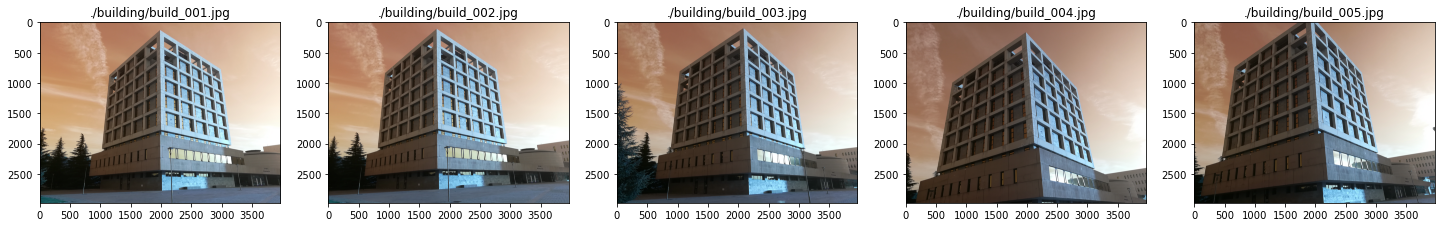

In [15]:
filenames = sorted(glob.glob('./building/*'))

# Abrimos las imágenes
imgs = load_images(filenames)

fig, axs = plt.subplots(1, len(imgs), figsize=(25, 6))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].set_title(filenames[i])

In [16]:
import pygame
import numpy as np
import cv2

import glob
import copy
import scipy.misc as scpm
import matplotlib.pyplot as plt



def load_images(filenames):
    """Load multiple images."""
    return [cv2.imread(filename) for filename in filenames]

filenames = sorted(glob.glob('./building/*'))

# Abrimos las imágenes
imgs = load_images(filenames)




def refinar(img, xp, yp, scale_x, scale_y, RAD = 14):

    # Reescalar y redondear las coordenadas de entrada (corregir inversión de pygame)
    x = round(yp * scale_y)
    y = round(xp * scale_x)

    # Extraer subimagen centrada en x, y
    s = img[x - RAD : x + RAD + 1, y - RAD : y + RAD + 1]
    
    gray = cv2.GaussianBlur(cv2.cvtColor(s, cv2.COLOR_BGR2GRAY),(5,5),0)
    dst = cv2.cornerHarris(gray, 8, 5, 0.04)
    
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, 0.3 * dst.max(), 255, 0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5),(-1, -1),criteria)
    
    corner = np.int0(np.mean(cv2.cornerSubPix(gray, np.float32(centroids), (5, 5),(-1, -1),criteria), axis=0))

    return (x - RAD + corner[1]), (y - RAD + corner[0])

def getCroppingMask(img, radio = 1, screen_width = 1600, screen_height = 900):
    # Rescale images
    scale_x = img.shape[1] / screen_width
    scale_y = img.shape[0] / screen_height
    
    imgr = cv2.resize(img, dsize=(screen_width, screen_height), interpolation=cv2.INTER_CUBIC)
    
    screen = pygame.display.set_mode(imgr.shape[-2::-1])
    
    imgpyg = pygame.image.frombuffer(imgr,imgr.shape[-2::-1],'RGB')
    screen.blit(imgpyg,(0,0))
    pygame.display.flip() # update the display
    
    polypoints = []

    while True:
        e = pygame.event.wait()
        if e.type == pygame.QUIT:
            break;
        if e.type == pygame.MOUSEBUTTONDOWN:
            x, y = e.pos
            xr, yr = refinar(img, x, y, scale_x, scale_y)
            if pygame.mouse.get_pressed()[0] or len(polypoints) <= 3:
                polypoints.append([yr, xr])
                x = round(yr / scale_x)
                y = round(xr / scale_y)
                if len(polypoints) == 1:
                    pygame.draw.circle(screen, (0,255,0), (x, y), radio)
                else:
                    pygame.draw.line(screen, (0,255,0), (round(polypoints[-2][0] / scale_x),round(polypoints[-2][1] / scale_y)), (x, y), radio)
            elif pygame.mouse.get_pressed()[2]:
                if len(polypoints) > 3:
                    pygame.draw.line(screen, (0,255,0), (round(polypoints[-1][0] / scale_x),round(polypoints[-1][1] / scale_y)), (round(polypoints[0][0] / scale_x),round(polypoints[0][1] / scale_y)), radio)
                    
        pygame.display.flip()
    
    pygame.quit()
    
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    points = np.array([polypoints])
    
    cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)

    return mask

masks = [getCroppingMask(img) for img in imgs]

pygame 2.0.0 (SDL 2.0.12, python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


error: OpenCV(4.4.0) ../modules/imgproc/src/drawing.cpp:2598: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'


Creamos aquí unas máscaras como las obtenidas en el código anterior para no tener que repetirlo.

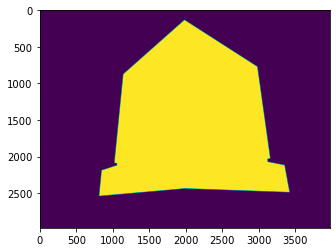

In [17]:
polypoints = [np.array([[[1976, 135], [2973, 773], [3149, 2023], [3111, 2032], [3114, 2072], [3345, 2117], [3413, 2485], [1984, 2434], [809, 2537], [843, 2188], [1053, 2119], [1056, 2092], [1018, 2084], [1139, 875]]]),
np.array([[[1786, 113], [2776, 776], [2948, 2000], [2909, 2013], [2912, 2048], [3133, 2091], [3195, 2447], [1802, 2413], [600, 2533], [639, 2175], [854, 2105], [861, 2081], [818, 2069], [935, 840]]]),
np.array([[[2082, 98], [2915, 857], [3088, 2085], [3062, 2084], [3063, 2114], [3272, 2181], [3329, 2543], [2207, 2472], [628, 2582], [684, 2198], [924, 2140], [929, 2099], [891, 2098], [1029, 815]]]),
np.array([[[1974, 169], [2808, 1075], [3103, 2407], [3071, 2417], [3320, 2524], [3411, 2964], [2264, 2873], [1530, 2958], [158, 2967], [236, 2617], [550, 2524], [560, 2489], [505, 2485], [760, 998]]]),
np.array([[[2763, 829], [3029, 2151], [2998, 2162], [3229, 2253], [3311, 2656], [2203, 2596], [109, 2866], [197, 2370], [504, 2276], [516, 2237], [458, 2234], [671, 740], [1702, 16], [2048, 20]]])]

masks = [cv2.drawContours(np.zeros(imgs[0].shape[0:2], dtype=np.uint8), [pps], -1, (255, 255, 255), -1, cv2.LINE_AA) for pps in polypoints]

plt.imshow(masks[0])

Ajustamos los parámetros de HoughLines.

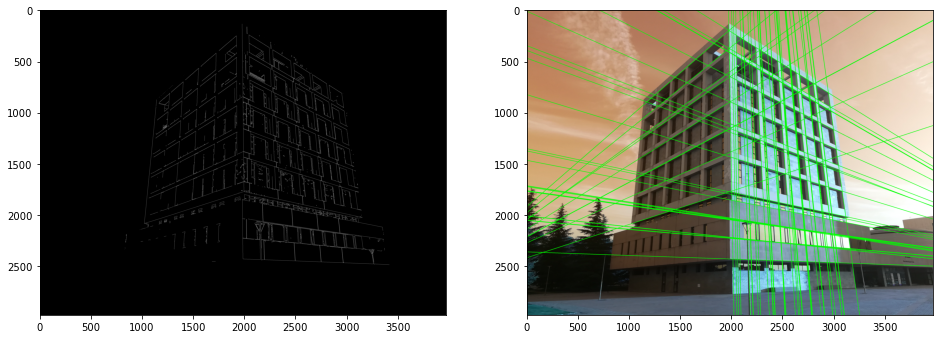

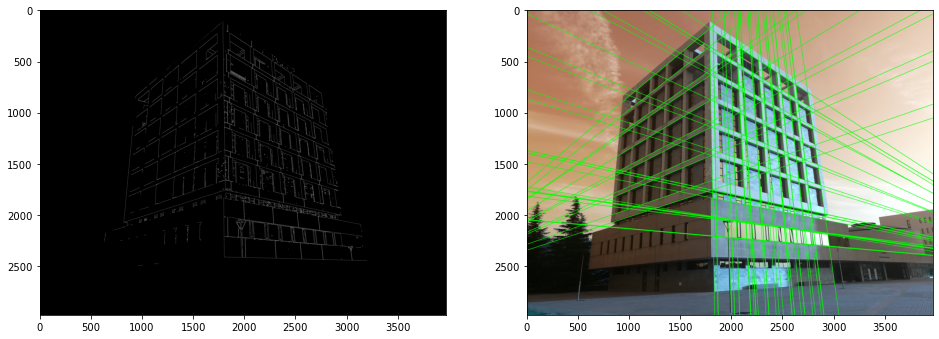

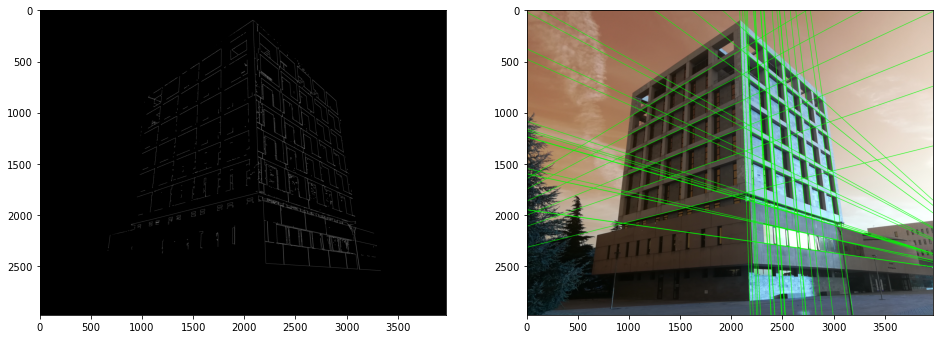

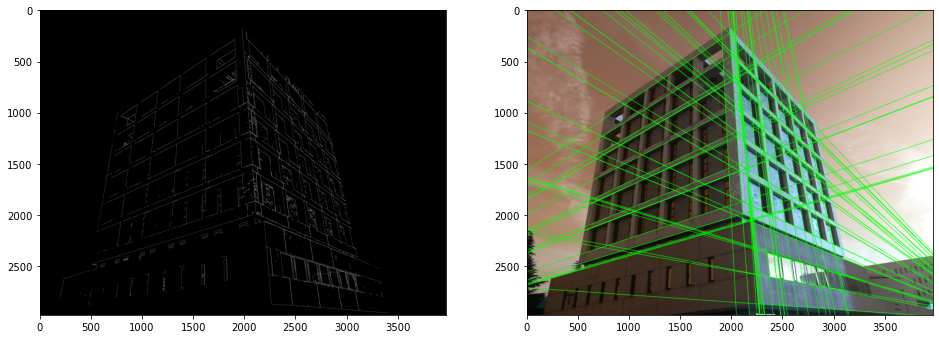

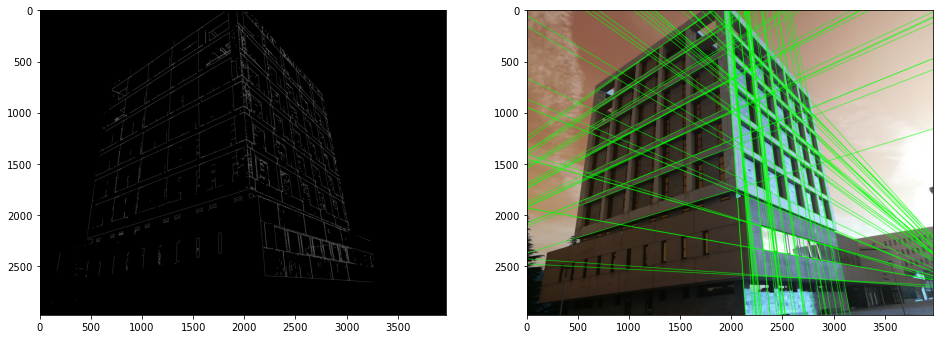

In [18]:
for i in range(len(imgs)):
    img = imgs[i].copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    canny = cv2.Canny(gray, 100, 180, 1)
    
    edges = cv2.bitwise_and(canny, canny, mask = masks[i])
    
    lines = cv2.HoughLines(edges, 1, np.pi/180, 250)
    for line in lines:
        rho,theta = line[0]
        # skip near-vertical lines
        if abs(theta-np.pi/90) < np.pi/9:
            continue
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 10000*(-b))
        y1 = int(y0 + 10000*(a))
        x2 = int(x0 - 10000*(-b))
        y2 = int(y0 - 10000*(a))
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),3)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(edges ,cmap = 'gray')
    axs[1].imshow(img)

A continuación buscaremos los puntos de fuga. Para ello usaremos el kmeans para hacer 3 clusters con las líneas y aproximaremos la intersección de las líneas de cada grupo, que se corresponderá con un punto de fuga.

<ipython-input-19-2d151619a52f>:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


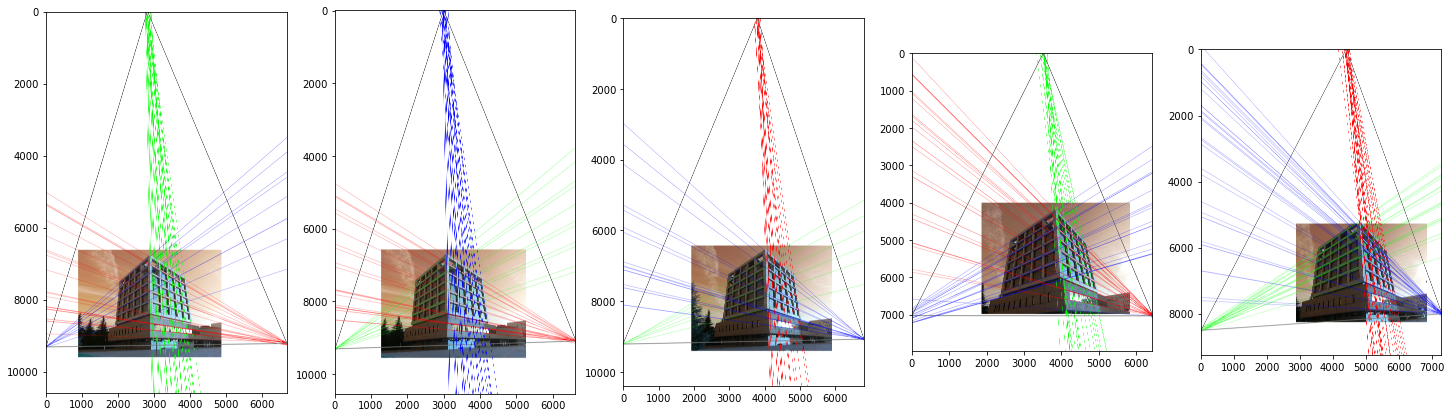

In [19]:
from collections import defaultdict

def segment_by_angle_kmeans(lines, k = 2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented



def segmented_intersections(lines):
    intersections = []
    
    for i in range(len(lines)):
        A = np.array([[np.cos(line[0][1]), np.sin(line[0][1])] for line in lines[i]])
        b = np.array([[line[0][0]] for line in lines[i]])
        x, _, _, _ = np.linalg.lstsq(A, b)
        x0, y0 = int(np.round(x[0])), int(np.round(x[1]))
        intersections.append([x0, y0])

    intersections = np.array(sorted(intersections))
        
    return intersections



fig, axs = plt.subplots(1, len(imgs), figsize=(25, 25))

vanishing_points = []

for i in range(len(imgs)):
    gray = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY)

    canny = cv2.Canny(gray, 100, 180, 1)
    
    edges = cv2.bitwise_and(canny, canny, mask = masks[i])

    lines = cv2.HoughLines(edges, 1, np.pi/180, 250)
    
    k = 3
    
    segmented = segment_by_angle_kmeans(lines, k)
    
    intersections = segmented_intersections(segmented)
    
    vanishing_points.append(intersections)
    
    maxx = max(intersections[:,0].max() + 1, imgs[i].shape[0])
    minx = min(intersections[:,0].min(), 0)
    maxy = max(intersections[:,1].max() + 1, imgs[i].shape[1])
    miny = min(intersections[:,1].min(), 0)
    imgwpts = 255 * np.ones(((maxy - miny), (maxx - minx), 3), dtype=np.uint8)
    imgwpts[-miny:img.shape[0]-miny, -minx:img.shape[1]-minx] = imgs[i][:,:] 
    
    for j in range(k):
        for l in range(3):
            cv2.line(imgwpts,(intersections[l][0] - minx, intersections[l][1] - miny), (intersections[l-1][0] - minx, intersections[l-1][1] - miny), (120,120, 120), 20)
    
        for line in segmented[j]:
            rho,theta = line[0]
            # skip near-vertical lines
            if abs(theta-np.pi/90) < np.pi/9:
                continue
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 10000*(-b))
            y1 = int(y0 + 10000*(a))
            x2 = int(x0 - 10000*(-b))
            y2 = int(y0 - 10000*(a))
            if j == 0:
                cv2.line(imgwpts,(x1 - minx,y1 - miny),(x2 - minx,y2 - miny),(0,255,0),3)
            elif j == 1:
                cv2.line(imgwpts,(x1 - minx,y1 - miny),(x2 - minx,y2 - miny),(255,0, 0),3)
            else:
                cv2.line(imgwpts,(x1 - minx,y1 - miny),(x2 - minx,y2 - miny),(0,0, 255),3)
    
    axs[i].imshow(imgwpts)

In [20]:
import scipy.linalg as la

# Calculamos K
K = []

for points in vanishing_points:
    A = np.array([
        [points[0][0] * points[1][0] + points[0][1] * points[1][1], points[0][0] + points[1][0], points[0][1] * points[1][1], 1],
        [points[0][0] * points[2][0] + points[0][1] * points[2][1], points[0][0] + points[2][0], points[0][1] * points[2][1], 1],
        [points[1][0] * points[2][0] + points[1][1] * points[2][1], points[1][0] + points[2][0], points[1][1] * points[2][1], 1]
    ])
    w = la.null_space(A)
    W = np.array([[w[0][0], 0, w[1][0]], [0, w[0][0], w[2][0]], [w[1][0], w[2][0], w[3][0]]])
    K.append(np.linalg.inv(np.linalg.cholesky(W)))


In [21]:
# Matriz de rotación O a 1
u = np.array([vanishing_points[0][0][0], vanishing_points[0][0][1], 1])
v = np.array([vanishing_points[0][2][0], vanishing_points[0][2][1], 1])

r3 = np.dot(np.linalg.inv(K[0]), u.T)
r1 = np.dot(np.linalg.inv(K[0]), v.T)
r2 = np.cross(r3, r1)

R = np.array([r1, r2, r3]).T
R01 = R / np.linalg.norm(R)

# Matriz de rotación O a 3
u = np.array([vanishing_points[2][0][0], vanishing_points[2][0][1], 1])
v = np.array([vanishing_points[2][2][0], vanishing_points[2][2][1], 1])

r3 = np.dot(np.linalg.inv(K[2]), u.T)
r1 = np.dot(np.linalg.inv(K[2]), v.T)
r2 = np.cross(r3, r1)

R = np.array([r1, r2, r3]).T
R03 = R / np.linalg.norm(R)

# Matriz de rotación 1 a 3
R13 = np.dot(np.linalg.inv(R01), R03) 
print(R13)

[[ 9.00870177e-01  2.87276446e-03 -1.53981242e-01]
 [-9.49499786e-06  1.08139370e+00  3.76708319e-06]
 [ 1.70773040e-01  1.84253876e-02  1.24263304e+00]]
